In [46]:
import pandas as pd
import gc
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Análisis de los datos:

Leemos todos los archivos para realizar un analisis sobre ellos

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc

# Cargar y concatenar los archivos CSV
file_names = ["ctr_15.csv", "ctr_16.csv", "ctr_17.csv", "ctr_18.csv", "ctr_19.csv", "ctr_20.csv", "ctr_21.csv"]
dataframes = [pd.read_csv(file) for file in file_names]
df = pd.concat(dataframes)
del dataframes
gc.collect()

# Filtrar filas donde label es 1
df_filtered = df[df['Label'] == 1]


#### Analisis de la tasa de conversión según dispositivo de los usuarios. 

Con aquellos usuarios cuya label toma valor 1, vimos con qué tipo de dispositivo se había metido cada uno a la página.

In [ ]:
# Crear el gráfico de barras para device_id_type con contornos
plt.figure(figsize=(10,5))
sns.countplot(
    x='device_id_type', 
    data=df_filtered, 
    order=df_filtered['device_id_type'].value_counts().index, 
    color="lightgreen", 
    edgecolor="black"  # Agregar contornos negros a las barras
)

plt.title('Tasa de conversión para cada tipo de dispositivo')
plt.xlabel('Device ID Type')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)  # Girar etiquetas si son muchas
plt.show()

# Mostrar los tipos distintos de device_id_type
distinct_devices = df_filtered['device_id_type'].unique()
print(f"Tipos de device_id_type distintos: {distinct_devices}")



In [ ]:
edades = df_filtered['auction_age']
indefinidos =0 
for i in edades:
    if i <= 14 or i >= 100:
        indefinidos += 1

# Crear una nueva columna que maneje las edades "indefinidas" y las clasifique en rangos
df_filtered['edad_categoria'] = pd.cut(
    edades, 
    bins=[0, 14, 25, 35, 45, 60, 100],  # Incluimos el rango 0-14 y 100+
    right=False, 
    labels=['Indefinido', '15-24', '25-34', '35-44', '45-59', '60-99']
)

# Crear el histograma para los rangos de edad, incluyendo la categoría "Indefinido"
plt.figure(figsize=(10,6))
sns.histplot(df_filtered['edad_categoria'], kde=False , color="brown")  # Histograma sin densidad
plt.title('Distribución de edades (label=1)')
plt.xlabel('Rango de Edad')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

# Contar cuántas edades caen en la categoría "Indefinido"
indefinidos = (edades <= 14).sum() + (edades >= 100).sum()
print(f"Cantidad de edades indefinidas (<=14 o >=100): {indefinidos}")

In [ ]:
# Filtrar filas donde label es 1
df_filtered = df[df['Label'].notnull()]

# Seleccionar solo las columnas numéricas
df_numeric = df_filtered.select_dtypes(include=['float64', 'int64'])

# Calcular la correlación de Pearson entre la columna Label y las demás variables numéricas
corr_matrix = df_numeric.corr()

# Filtrar solo las correlaciones con la columna 'Label'
corr_with_label = corr_matrix[['Label']].sort_values(by='Label', ascending=False)

print(corr_with_label)


In [ ]:
# Filtrar filas donde Label no es nulo
df_filtered = df[df['Label'].notnull()]
df_filtered['auction_categorical_2'].fillna(0, inplace=True)


# Variables categóricas utilizadas en las interacciones


interaction_columns = [ 
    'device_id_type', 
    'gender', 
    'auction_categorical_0', 'auction_categorical_1', 
    'auction_categorical_2', 'auction_categorical_3',
    'auction_categorical_4', 'auction_categorical_5', 
    'auction_categorical_6', 'auction_categorical_7', 
    'auction_categorical_8', 'auction_categorical_9', 
    'auction_categorical_10', 'auction_categorical_11', 
    'auction_categorical_12', 
    'action_categorical_0', 'action_categorical_1', 
    'action_categorical_2', 'action_categorical_3', 
    'action_categorical_4', 'action_categorical_5',
    'action_categorical_6', 'action_categorical_7', 
    'creative_categorical_0','creative_categorical_1',
    'creative_categorical_2','creative_categorical_3',
    'creative_categorical_4', 'creative_categorical_5', 
    'creative_categorical_6', 'creative_categorical_7', 
    'creative_categorical_8', 'creative_categorical_9'


]

# Count Encoding para las variables categóricas de interacción
for column in interaction_columns:
    df_filtered[f'{column}'] = df_filtered[column].map(df_filtered[column].value_counts())

# Calcular la correlación solo con columnas numéricas
numeric_cols = df_filtered.select_dtypes(include=['number']).columns
corr_matrix = df_filtered[numeric_cols].corr()

# Calcular las correlaciones de Label
label_corr = corr_matrix['Label'].sort_values(ascending=False)

# Filtrar solo las columnas de interacción codificadas
encoded_columns = [f'{column}' for column in interaction_columns]
label_corr_filtered = label_corr[label_corr.index.isin(['Label'] + encoded_columns)]

# Mostrar las correlaciones de Label con las variables categóricas de interacción
print("\nCorrelaciones entre Label y variables categóricas de interacción:")
print(label_corr_filtered)


In [ ]:
# Filtrar las correlaciones para excluir 'label'
label_corr_filtered = label_corr[label_corr.index != 'Label']

# Eliminar el sufijo '_count_encoded' de los nombres de las variables
label_corr_filtered.index = label_corr_filtered.index.str.replace('_count_encoded', '')

# Graficar las correlaciones sin el sufijo y sin nombres en los ejes ni en el título
plt.figure(figsize=(15, 6))
sns.barplot(x=label_corr_filtered.index, y=label_corr_filtered.values, palette='coolwarm_r')
plt.title('')  # Título vacío
plt.xlabel('')  # Etiqueta del eje X vacía
plt.ylabel('')  # Etiqueta del eje Y vacía

# Cambiar la escala de los ejes
plt.ylim(-0.1, 0.1)  # Ajusta los límites del eje Y
plt.axhline(0, color='black', linestyle='-')  # Línea en y=0 para referencia
plt.xticks(rotation=90)
plt.show()


In [ ]:
# Filtrar filas donde Label no es nulo
df_filtered = df[df['Label'].notnull()]

# Identificar variables categóricas
categorical_columns = [
    'action_categorical_0', 'action_categorical_1', 'action_categorical_2',
    'action_categorical_3', 'action_categorical_4', 'action_categorical_5',
    'action_categorical_6', 'action_categorical_7', 
    'auction_categorical_0', 'auction_categorical_1', 
    'auction_categorical_2', 'auction_categorical_3',
    'auction_categorical_4', 'auction_categorical_5', 
    'auction_categorical_6', 'auction_categorical_7', 
    'auction_categorical_8', 'auction_categorical_9', 
    'auction_categorical_10', 'auction_categorical_11', 
    'auction_categorical_12', 
    'creative_categorical_0', 'creative_categorical_1', 
    'creative_categorical_2', 'creative_categorical_3', 
    'creative_categorical_4', 'creative_categorical_5', 
    'creative_categorical_6', 'creative_categorical_7', 
    'creative_categorical_8', 'creative_categorical_9'
]

# Aplicar one-hot encoding a las variables categóricas
df_encoded = pd.get_dummies(df_filtered, columns=categorical_columns, drop_first=True)

# Calcular la correlación con la variable Label
corr_matrix = df_encoded.corr()
label_corr = corr_matrix['Label'].sort_values(ascending=False)

# Mostrar las correlaciones de Label con las variables categóricas
print("Correlaciones entre Label y variables categóricas:")
print(label_corr)

# Graficar las correlaciones
plt.figure(figsize=(12, 8))
sns.barplot(x=label_corr.index, y=label_corr.values, palette='viridis')
plt.title('Correlaciones entre Label y Variables Categóricas')
plt.xlabel('Variables')
plt.ylabel('Correlación')
plt.xticks(rotation=90)
plt.axhline(0, color='red', linestyle='--')  # Línea en y=0 para referencia
plt.show()

In [ ]:
# Ordenar el DataFrame por importancia
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizar las importancias de las características
plt.figure(figsize=(10, 12))
sns.barplot(data=feature_importance_df.head(40), x='Importance', y='Feature', color='violet')
plt.title('Top 40 Importancias de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

Creamos los archivos de training y validation

In [47]:
# Cargamos los datos
train_data = pd.read_csv("ctr_19.csv")
eval_data = pd.read_csv("ctr_test.csv")

# Preparamos los datos
train_data = train_data.sample(frac=1)  # Reorganizar aleatoriamente
y = train_data["Label"]
X = train_data.drop(columns=["Label"])

# Creo el archivo de entrenamiento, lo creamos con casi todos los daros del mismo.
X_train, excedente_x, y_train, excedente_y = train_test_split(X, y, test_size=0.00001, random_state=2345)

# Eliminamos las variables que no utilizamos más para limpiar memoria 
del train_data, X, y
gc.collect()

# Ahora creamos nuestro archivo de validación
file_names = ["ctr_15.csv","ctr_16.csv", "ctr_17.csv","ctr_18.csv"]

dataframes = []
for file in file_names:
    df = pd.read_csv(file)  # Cargar el archivo CSV
    dataframes.append(df)  # Agregar a la lista

# Concatenar todos los DataFrames en uno solo
new_data = pd.concat(dataframes, ignore_index=True)  

# Extraer las etiquetas y características de los nuevos datos
new_labels = new_data["Label"]
new_features = new_data.drop(columns=["Label"])

# Concatenar los datos existentes y los nuevos
X_val = pd.concat([excedente_x, new_features], axis=0)
y_val = pd.concat([excedente_y, new_labels], axis=0)

# Volvemos a eliminar las variables que no utilizamos.
del new_data,new_features,new_labels,dataframes
gc.collect()

58264

Nuesto mejor código

Hacemos un gráfico con la tasa de conversión según edades del csv

In [ ]:
# Cargamos los datos
train_data = pd.read_csv("ctr_19.csv")
eval_data = pd.read_csv("ctr_test.csv")

# Preparamos los datos
train_data = train_data.sample(frac=1)  # Reorganizar aleatoriamente
y = train_data["Label"]
X = train_data.drop(columns=["Label"])

# Creo el archivo de entrenamiento, lo creamos con casi todos los daros del mismo.
X_train, excedente_x, y_train, excedente_y = train_test_split(X, y, test_size=0.00001, random_state=2345)

# Eliminamos las variables que no utilizamos más para limpiar memoria 
del train_data, X, y
gc.collect()

# Ahora creamos nuestro archivo de validación
file_names = ["ctr_15.csv","ctr_16.csv", "ctr_17.csv","ctr_18.csv","ctr_19.csv","ctr_20.csv","ctr_21.csv"]

dataframes = []
for file in file_names:
    df = pd.read_csv(file)  # Cargar el archivo CSV
    dataframes.append(df)  # Agregar a la lista

# Concatenar todos los DataFrames en uno solo
new_data = pd.concat(dataframes, ignore_index=True)  

# Extraer las etiquetas y características de los nuevos datos
new_labels = new_data["Label"]
new_features = new_data.drop(columns=["Label"])

# Concatenar los datos existentes y los nuevos
X_val = pd.concat([excedente_x, new_features], axis=0)
y_val = pd.concat([excedente_y, new_labels], axis=0)

# Volvemos a eliminar las variables que no utilizamos.
del new_data,new_features,new_labels,dataframes
gc.collect()

Creamos nuestro modelo de xgboost

In [51]:
# Selección de características numéricas y categóricas
num_features = X_train.select_dtypes(include='number').columns.tolist()
cat_features = X_train.select_dtypes(include='object').columns.tolist()

# Pipelines de preprocesamiento
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='mean')  # Eliminado PolynomialFeatures para mayor rapidez
)
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),  # Imputar categóricos con la moda
    OneHotEncoder(handle_unknown='ignore')    # OneHotEncoder para categorías
    
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

# Modelo con XGBoost
pipeline = make_pipeline(
    preprocessor, 
    XGBClassifier(random_state=2345, use_label_encoder=False, eval_metric='logloss')
)

#Creamos los rangos de los hiperparametros para el random search.
param_dist = {
    'xgbclassifier__n_estimators': randint(50, 200), #Cantidad de arboles que hace el modelo
    'xgbclassifier__max_depth': randint(3, 10), #La máxima profundida a la que le permitimos al arbol llegar
    'xgbclassifier__learning_rate': uniform(0.05, 0.15), #tasa de aprendizaje
    'xgbclassifier__subsample': uniform(0.6, 0.4),   
    'xgbclassifier__colsample_bytree': uniform(0.3, 0.7),  
    'xgbclassifier__min_child_weight': randint(1, 6), # Peso mínimo de las hojas
    'xgbclassifier__gamma': uniform(0, 5), # Penalización por complejidad del árbol
    'xgbclassifier__reg_alpha': uniform(0, 0.5), # Regularización L1 (Lasso)
    'xgbclassifier__reg_lambda': uniform(1, 5)  # Regularización L2 (Ridge)
}


Creamos las interacciones entre algunas variables del archivo.

In [48]:

def add_interactions(df):

    # interacciones numéricas
    df['auction_age_bidfloor'] = df['auction_age'] * df['auction_bidfloor']
    df['auction_time_bidfloor'] = df['auction_time'] * df['auction_bidfloor']
    df['auction_age_time'] = df['auction_age'] * df['auction_time']
    
    # combinaciones cuadráticas
    df['auction_age_squared'] = df['auction_age'] ** 2
    df['auction_bidfloor_squared'] = df['auction_bidfloor'] ** 2

    # Relación entre el tamaño de la creatividad y el bidfloor
    df['creative_area_bidfloor'] = (df['creative_height'] * df['creative_width']) * df['auction_bidfloor']
    
    # Interacciones categóricas
    df['action_creative_interaction'] = df['action_categorical_0'].astype(str) + '_' + df['creative_categorical_0'].astype(str)
    df['device_gender_interaction'] = df['device_id_type'].astype(str) + '_' + df['gender'].astype(str)
    df['action_full_hierarchy'] = df['action_categorical_0'].astype(str) + '_' + df['action_categorical_1'].astype(str) + '_' + df['action_categorical_2'].astype(str)
    
    # Interacciones categóricas y numéricas
    df['bidfloor_creative_size'] = df['auction_bidfloor'] * (df['creative_height'] * df['creative_width'])

    # listas en su longitud como nueva característica
    df['action_list_0_length'] = df['action_list_0'].apply(lambda x: len(str(x).split(',')))
    df['action_list_1_length'] = df['action_list_1'].apply(lambda x: len(str(x).split(',')))
    df['action_list_2_length'] = df['action_list_2'].apply(lambda x: len(str(x).split(',')))

    # Sumar la longitud de las listas
    df['total_action_list_length'] = df['action_list_0_length'] + df['action_list_1_length'] + df['action_list_2_length']

    # ratio entre las listas
    df['action_list_0_ratio'] = df['action_list_0_length'] / (df['total_action_list_length'] + 1)  # Para evitar división por cero
    
    # Interacciones booleanas
    df['auction_combined_boolean'] = df['auction_boolean_0'].astype(bool) & df['auction_boolean_1'].astype(bool) & df['auction_boolean_2'].astype(bool)
    
    # Interacciones con diferencias y ratios
    df['time_bidfloor_diff'] = df['auction_time'] - df['auction_bidfloor']
    df['creative_aspect_ratio'] = df['creative_height'] / df['creative_width']

    return df


Le aplicamos las interacciones a los conjuntos de training y validation.

In [49]:
X_train = add_interactions(X_train)
X_val = add_interactions(X_val)

Realizamos el Random Search

In [52]:

# Random search con validación cruzada
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_dist, n_iter=5, scoring='roc_auc',  # Bajo iteraciones para que corra más rapido
    cv=3, verbose=1, random_state=2345, n_jobs=1  # Usar todos los núcleos disponibles para que se corra más rápido
)

# Ajustar el modelo con Random Search
random_search.fit(X_train, y_train)

# Mejor modelo
best_model = random_search.best_estimator_


Fitting 3 folds for each of 5 candidates, totalling 15 fits


/Users/jazsneider/miniconda3/envs/TD6/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:47:13] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jazsneider/miniconda3/envs/TD6/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:48:45] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jazsneider/miniconda3/envs/TD6/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:50:16] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/

Vemos el resultado de las predicciones con el conjunto de validación y de training

In [19]:
# Predecimos y calcular AUC-ROC
y_pred_proba = best_model.predict_proba(X_val)[:, 1]
auc_roc = roc_auc_score(y_val, y_pred_proba)
print(f'AUC-ROC del conjunto de validación: {auc_roc}')

# Obtener las probabilidades predichas para el conjunto de entrenamiento
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]  # Clase positiva (probabilidad de 1)

# Calcular el AUC-ROC
auc_train = roc_auc_score(y_train, y_train_pred_proba)

print(f"AUC-ROC del conjunto de entrenamiento: {auc_train:.4f}")

AUC-ROC: 0.8464363880224972


Imprimimos los mejores hiperparametros encontrados por el random search

In [ ]:
# mejores parámetros encontrados
print(random_search.best_params_)

Creamos el archivo que vamos a subir.

In [23]:

eval_data_preprocessed = add_interactions(eval_data.drop(columns=["id"]))

# columnas numéricas y categóricas de eval_data coincidan con X_train
eval_data_preprocessed = eval_data_preprocessed[num_features + cat_features]

y_preds = best_model.predict_proba(eval_data_preprocessed)[:, best_model.classes_ == 1].squeeze()
submission_df = pd.DataFrame({"id": eval_data["id"], "Label": y_preds})
submission_df["id"] = submission_df["id"].astype(int)
submission_df.to_csv("xboostingenieria_agregadoHPv3_rnds.csv", sep=",", index=False)

{'xgbclassifier__colsample_bytree': 0.751631255571052, 'xgbclassifier__gamma': 0.6855221137475576, 'xgbclassifier__learning_rate': 0.135589679215216, 'xgbclassifier__max_depth': 6, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__n_estimators': 137, 'xgbclassifier__reg_alpha': 1.3114403256597402, 'xgbclassifier__reg_lambda': 4.22939460165496, 'xgbclassifier__subsample': 0.6994549411703712}


## Análisis de las variables luego de nuestro modelo


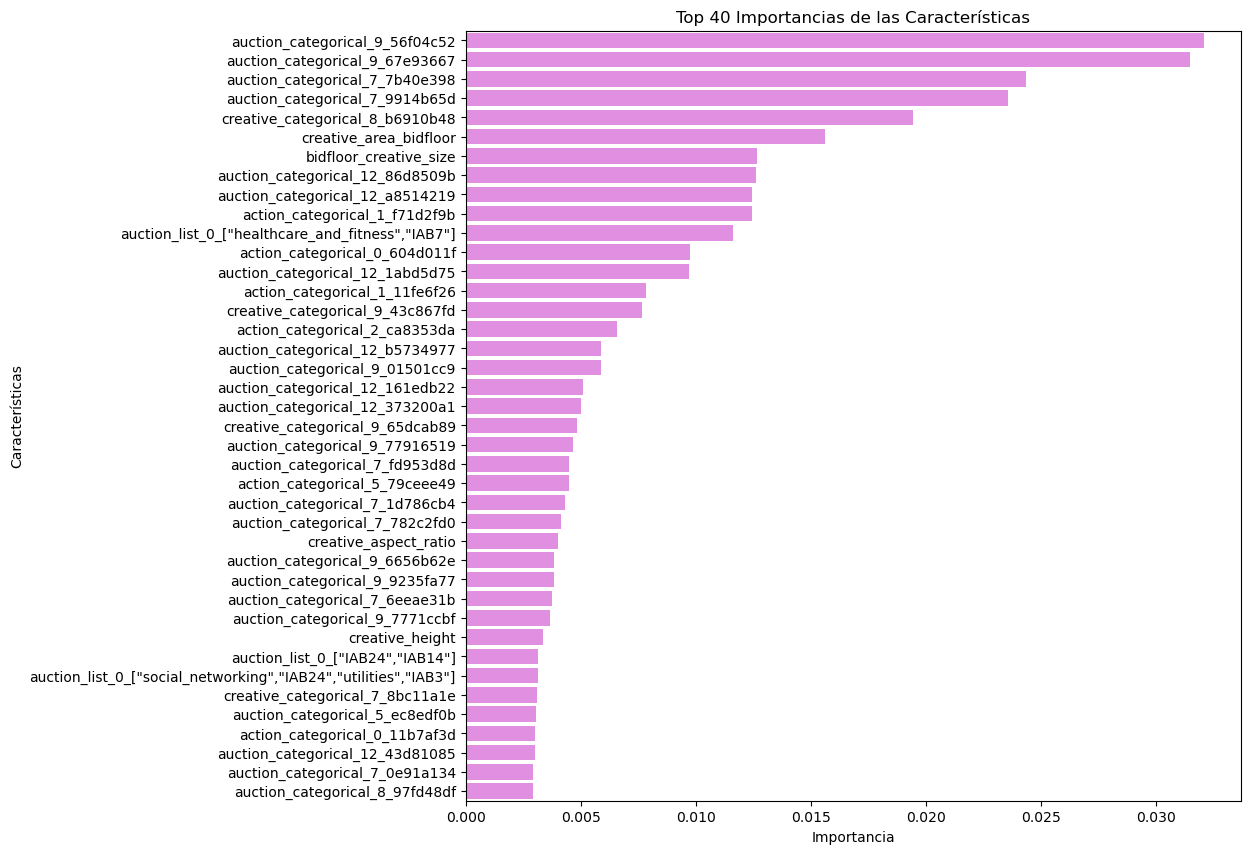

In [84]:
# Acceder al preprocesador (ColumnTransformer) y al modelo final (XGBClassifier)
preprocessor = best_model.named_steps["columntransformer"]
model = best_model.named_steps['xgbclassifier']

# Nombres de las características numéricas y categóricas originales
numeric_feature_names = num_features  # Lista de tus características numéricas
categorical_feature_names = cat_features  # Lista de tus características categóricas

# Obtener nombres de características después del OneHotEncoder
# Encontrar el OneHotEncoder dentro del preprocesador
ohe = preprocessor.transformers_[1][1].named_steps['onehotencoder']

# Obtener los nombres de las características transformadas
transformed_categorical_feature_names = ohe.get_feature_names_out(categorical_feature_names)

# Combinar los nombres de las características numéricas y categóricas
feature_names = np.concatenate([numeric_feature_names, transformed_categorical_feature_names])

# Extraer las importancias de las características del modelo XGBoost
importances = model.feature_importances_

# Crear un DataFrame con la importancia de las características
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Ordenar el DataFrame por importancia
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizar las importancias de las características
plt.figure(figsize=(10, 10))
sns.barplot(data=feature_importance_df.head(40), x='Importance', y='Feature', color='violet')
plt.title('Top 40 Importancias de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()
